In [1]:
import os.path
from constant import *
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import ks_2samp
from data import loader, exporter
import matplotlib.pyplot as plt

In [6]:
def adversarial_validation_with_lightgbm(df, delete_ks_threshold=0.1):

   # Step 1: 分割训练集和测试集数据
    train_data = df[df['SRC'] == 'train']
    test_data = df[df['SRC'] == 'test']

    # 检查哪些特征仅在训练集或测试集中存在
    train_columns = set(train_data.columns)
    test_columns = set(test_data.columns)
    
    # 计算需要删除的特征（仅存在于训练集或测试集中的特征）
    exclusive_train_columns = train_columns - test_columns
    exclusive_test_columns = test_columns - train_columns
    columns_to_drop = list(exclusive_train_columns | exclusive_test_columns)

    # 检查是否存在列在测试集中全部为NaN或0的情况，或方差为0
    for feature in train_columns & test_columns:
        if test_data[feature].isna().all() or (test_data[feature] == 0).all() :
            columns_to_drop.append(feature)

    if columns_to_drop:
        print(f"Columns only in train or test, or have all NaN/0 in test, and will be dropped: {columns_to_drop}")

    # 剔除这些列
    df = df.drop(columns=columns_to_drop)

    # 分割成训练集和验证集
    y = df["SRC"].apply(lambda x: 1 if x == 'train' else 0)
    X = df.drop(columns=['SRC', 'CUST_NO'])

    feature_columns = X.columns.tolist()

    # 使用lightgbm进行分类
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)
    train_data_lgb = lgb.Dataset(X_train, label=y_train)
    valid_data_lgb = lgb.Dataset(X_valid, label=y_valid, reference=train_data_lgb)

    # 使用LightGBM训练
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'early_stopping_round': 50
    }

    lgb_model = lgb.train(params, train_data_lgb, valid_sets=[valid_data_lgb])

    # 计算ROC AUC分数
    y_pred = lgb_model.predict(X_valid, num_iteration=lgb_model.best_iteration)
    auc_score = roc_auc_score(y_valid, y_pred)

    print(f"Adversarial Validation AUC: {auc_score:.4f}")

    # 绘制多个特征的分布图在一个图表中
    num_features = len(feature_columns)

    # 创建子图时，根据特征数量确定布局
    if num_features == 1:
        fig, ax = plt.subplots(figsize=(12, 6))
        sns.kdeplot(train_data[feature_columns[0]], label='Train', fill=True, ax=ax)
        sns.kdeplot(test_data[feature_columns[0]], label='Test', fill=True, ax=ax)
        ax.set_title(f"Distribution of {feature_columns[0]} in Train vs Test")
        ax.legend()
    else:
        fig, axes = plt.subplots(nrows=num_features // 2 + num_features % 2, ncols=2,
                                 figsize=(12, 6 * (num_features // 2)))
        axes = axes.flatten()

        for i, feature in enumerate(feature_columns):
            sns.kdeplot(train_data[feature], label='Train', fill=True, ax=axes[i])
            sns.kdeplot(test_data[feature], label='Test', fill=True, ax=axes[i])
            axes[i].set_title(f"Distribution of {feature} in Train vs Test")
            axes[i].legend()

    plt.tight_layout()
    plt.show()
    

    # Step 4: 计算特征在训练集和测试集中的 KS 检验差异
    columns_to_drop = []
    ks_results = []
    for feature in feature_columns:
        train_values = train_data[feature].dropna()
        test_values = test_data[feature].dropna()
        
        # var = 0 
        if test_values.var() == 0 or train_values.var() == 0:
            columns_to_drop.append(feature)
        
        # ks 大于阈值的
        statistic, p_value = ks_2samp(train_values, test_values)
        
        if statistic > delete_ks_threshold:
            columns_to_drop.append(feature)
        
        ks_results.append({'feature': feature, 'ks_statistic': statistic, 'p_value': p_value})
    
    # 显示 KS 检验结果
    ks_df = pd.DataFrame(ks_results).sort_values(by='ks_statistic', ascending=False)
    print("KS test results:")
    print(ks_df)

    # Step 5: 剔除 KS 差异过大的列
    if columns_to_drop:
        print(f"Columns with large KS difference and will be dropped: {columns_to_drop}")
        X = X.drop(columns=columns_to_drop)

    # 返回最终保留的特征列
    retained_features = X.columns.tolist()
    return retained_features




Columns only in train or test, or have all NaN/0 in test, and will be dropped: ['ENTSTATUS_迁出', 'FLAG']
[1]	valid_0's auc: 0.500509
Training until validation scores don't improve for 50 rounds
[2]	valid_0's auc: 0.502383
[3]	valid_0's auc: 0.500582
[4]	valid_0's auc: 0.502824
[5]	valid_0's auc: 0.498909
[6]	valid_0's auc: 0.497175
[7]	valid_0's auc: 0.496213
[8]	valid_0's auc: 0.494514
[9]	valid_0's auc: 0.494872
[10]	valid_0's auc: 0.495663
[11]	valid_0's auc: 0.497058
[12]	valid_0's auc: 0.499088
[13]	valid_0's auc: 0.497845
[14]	valid_0's auc: 0.497133
[15]	valid_0's auc: 0.497225
[16]	valid_0's auc: 0.496598
[17]	valid_0's auc: 0.495273
[18]	valid_0's auc: 0.494604
[19]	valid_0's auc: 0.494089
[20]	valid_0's auc: 0.493005
[21]	valid_0's auc: 0.494469
[22]	valid_0's auc: 0.496422
[23]	valid_0's auc: 0.495993
[24]	valid_0's auc: 0.495226
[25]	valid_0's auc: 0.496905
[26]	valid_0's auc: 0.496889
[27]	valid_0's auc: 0.496402
[28]	valid_0's auc: 0.495407
[29]	valid_0's auc: 0.495947
[30

C:\Users\zangq\AppData\Local\Temp\ipykernel_160704\420217065.py:71: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(test_data[feature], label='Test', fill=True, ax=axes[i])
C:\Users\zangq\AppData\Local\Temp\ipykernel_160704\420217065.py:71: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(test_data[feature], label='Test', fill=True, ax=axes[i])
C:\Users\zangq\AppData\Local\Temp\ipykernel_160704\420217065.py:70: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(train_data[feature], label='Train', fill=True, ax=axes[i])
C:\Users\zangq\AppData\Local\Temp\ipykernel_160704\420217065.py:71: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(test_data[feature], label='Test', f

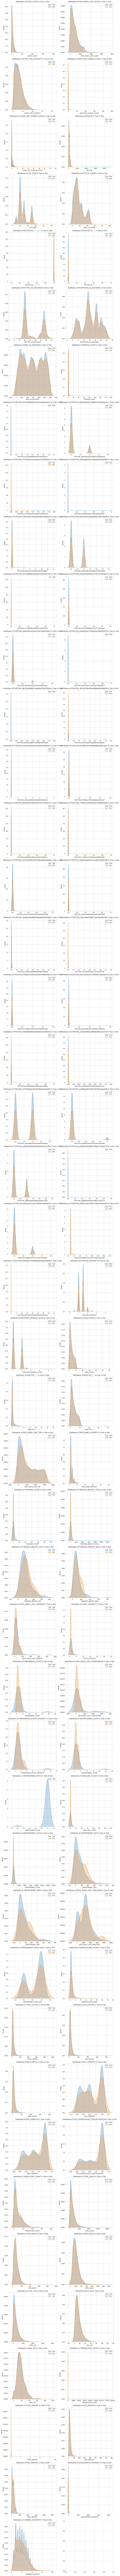

KS test results:
                                      feature  ks_statistic   p_value
59                DAYS_SINCE_LAST_PUNISHBREAK      0.233333  0.881497
58                          PUNISHBREAK_COUNT      0.208333  0.941415
61                          UNPERFORMED_COUNT      0.208333  0.941415
66                            UNPERFMONEY_MAX      0.179452  0.321035
65                            UNPERFMONEY_AVG      0.162557  0.438606
..                                        ...           ...       ...
8                            ENTSTATUS_在营（开业）      0.000061  1.000000
16  POSITION_1d15708e2c42cc5ebabc515490243dc0      0.000061  1.000000
23  POSITION_52ad39cfacc17202a45ae1068d545415      0.000058  1.000000
41  POSITION_eda8f36923b3d8671889ee17aed27723      0.000058  1.000000
17  POSITION_2208c0826463c1e99ea8030c9c65df4f      0.000039  1.000000

[89 rows x 3 columns]
Columns with large KS difference and will be dropped: ['POSITION_042160c9f6948919cd615cb044e5ee1c', 'POSITION_2208c08264

In [9]:
df = loader.to_df(os.path.join(dir_preprocess, 'v1.csv'))
retained_features = adversarial_validation_with_lightgbm(df)


Columns only in train or test, or have all NaN/0 in test, and will be dropped: ['FLAG']
[1]	valid_0's auc: 0.500609
Training until validation scores don't improve for 50 rounds
[2]	valid_0's auc: 0.502304
[3]	valid_0's auc: 0.500597
[4]	valid_0's auc: 0.504769
[5]	valid_0's auc: 0.49926
[6]	valid_0's auc: 0.498643
[7]	valid_0's auc: 0.49833
[8]	valid_0's auc: 0.500711
[9]	valid_0's auc: 0.499307
[10]	valid_0's auc: 0.500565
[11]	valid_0's auc: 0.500902
[12]	valid_0's auc: 0.49847
[13]	valid_0's auc: 0.495798
[14]	valid_0's auc: 0.497026
[15]	valid_0's auc: 0.494646
[16]	valid_0's auc: 0.496407
[17]	valid_0's auc: 0.49862
[18]	valid_0's auc: 0.499973
[19]	valid_0's auc: 0.498902
[20]	valid_0's auc: 0.498393
[21]	valid_0's auc: 0.499585
[22]	valid_0's auc: 0.500716
[23]	valid_0's auc: 0.499715
[24]	valid_0's auc: 0.499287
[25]	valid_0's auc: 0.497426
[26]	valid_0's auc: 0.496404
[27]	valid_0's auc: 0.496323
[28]	valid_0's auc: 0.498917
[29]	valid_0's auc: 0.497946
[30]	valid_0's auc: 0.4

C:\Users\zangq\AppData\Local\Temp\ipykernel_160704\420217065.py:75: UserWarning: Glyph 22312 (\N{CJK UNIFIED IDEOGRAPH-5728}) missing from current font.
  plt.tight_layout()
C:\Users\zangq\AppData\Local\Temp\ipykernel_160704\420217065.py:75: UserWarning: Glyph 33829 (\N{CJK UNIFIED IDEOGRAPH-8425}) missing from current font.
  plt.tight_layout()
C:\Users\zangq\AppData\Local\Temp\ipykernel_160704\420217065.py:75: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  plt.tight_layout()
C:\Users\zangq\AppData\Local\Temp\ipykernel_160704\420217065.py:75: UserWarning: Glyph 24320 (\N{CJK UNIFIED IDEOGRAPH-5F00}) missing from current font.
  plt.tight_layout()
C:\Users\zangq\AppData\Local\Temp\ipykernel_160704\420217065.py:75: UserWarning: Glyph 19994 (\N{CJK UNIFIED IDEOGRAPH-4E1A}) missing from current font.
  plt.tight_layout()
C:\Users\zangq\AppData\Local\Temp\ipykernel_160704\420217065.py:75: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) mis

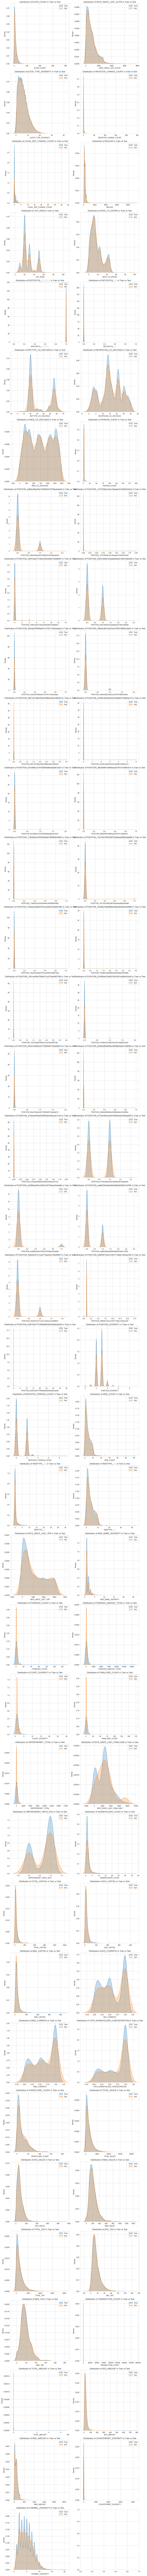

KS test results:
                                      feature  ks_statistic   p_value
51                  DAYS_SINCE_LAST_FINALCASE      0.097189  0.854807
47                      PUNISHED_AMOUNT_TOTAL      0.092538  0.939766
50                          UNPERFMONEY_TOTAL      0.073636  0.981593
56                                MAX_CAPITAL      0.073347  0.217277
55                                AVG_CAPITAL      0.071627  0.240422
..                                        ...           ...       ...
28  POSITION_7e91acf0d47f0bfc27ce27ba048375bf      0.000077  1.000000
24  POSITION_718d263cd163934b9eb7685ff2644984      0.000075  1.000000
9                                ENTSTATUS_注销      0.000070  1.000000
8                            ENTSTATUS_在营（开业）      0.000061  1.000000
15  POSITION_1d15708e2c42cc5ebabc515490243dc0      0.000061  1.000000

[73 rows x 3 columns]


['ALTER_COUNT',
 'DAYS_SINCE_LAST_ALTER',
 'ALTER_TYPE_DIVERSITY',
 'INVESTOR_CHANGE_COUNT',
 'LEGAL_REP_CHANGE_COUNT',
 'REGCAP',
 'LIFE_SPAN',
 'DAYS_TO_EXPIRE',
 'ENTSTATUS_在营（开业）',
 'ENTSTATUS_注销',
 'ENTTYPE_CD_ENCODED',
 'REGPROVIN_CD_ENCODED',
 'INDS_CD_ENCODED',
 'PERSON_COUNT',
 'POSITION_0d95e39be30a1538562416756e4a0e42',
 'POSITION_1d15708e2c42cc5ebabc515490243dc0',
 'POSITION_236f15ad3772b0c93f2c68e7529d6e97',
 'POSITION_25b47d6287e5aadb9ebe518df1c6b838',
 'POSITION_454cbd7f594fee07cc74471428cbdae2',
 'POSITION_465e0c8b7bd22ced73f251f86b43ddd1',
 'POSITION_58413d158bcf3fac0086e4e63c28b044',
 'POSITION_5c455c3e9455224d1b60bf72358b3a14',
 'POSITION_637ef98cc019182f50b68ea83a81a5a7',
 'POSITION_68292f0f01d884ea3307615139953cf1',
 'POSITION_718d263cd163934b9eb7685ff2644984',
 'POSITION_742143d19003367b5a5bee606b2e8e88',
 'POSITION_74ed2ec8da63476cced48572e8487a82',
 'POSITION_78c86a7e6e9866e36ab09afc9e35096b',
 'POSITION_7e91acf0d47f0bfc27ce27ba048375bf',
 'POSITION_81496de153e6

In [10]:
df_after_adv = df[retained_features + ['CUST_NO','SRC','FLAG']]
adversarial_validation_with_lightgbm(df_after_adv)